In [ ]:
# Jupyter notebook
# by J. Barthel, Ernst Ruska-Centre (ER-C 2)
# Forschungszentrum Juelich GmbH, Germany
# email: ju.barthel@fz-juelich.de
# ------------------------------------------
#
# Demonstration of measuring focus-spread from an image of thin amorphous
# recorded under tilted beam illumination and significant defocus.
# The applied tilt should be around twice as large as the information limit
# caused by the focus spread. Under such conditions a strong anisotropic
# attenuation of the Thon ring pattern should be visible in the diffractogram.
# Method: J. Barthel, A. Thust, Phys. Rev. Lett. 101 (2008) 200801.
#

In [3]:
import numpy as np
from emilys.optics.econst import ht2wl
from emilys.optics.focusspread import measure_fs_lf, info_limit
from emilys.image.imagedata import image_load, image_diffractogram
from emilys.image.manipulations import replace_area_from_random_surrounding
from emilys.image.thonrings import lp_filter, lf_component
from emilys.image.arrayplot import arrayplot2d
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
%matplotlib inline

diffractogram q_max = 3.145 1/nm


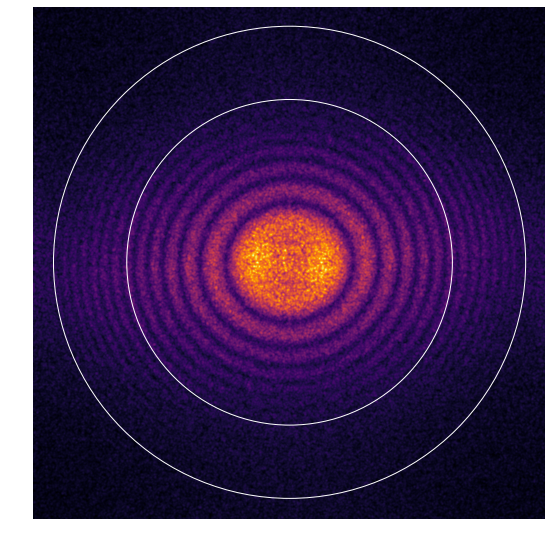

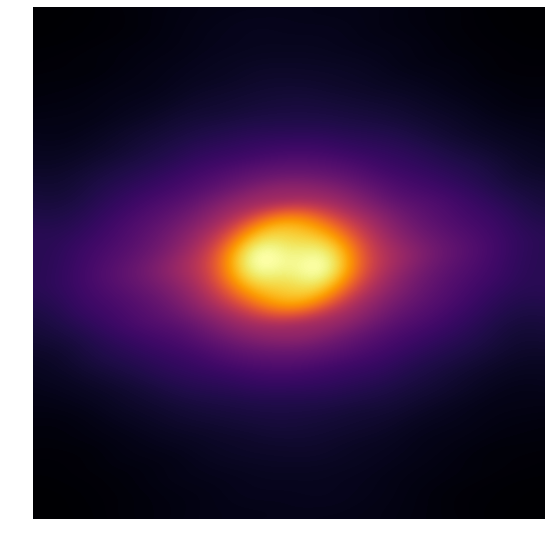

In [27]:
# --- user input required below this line ---
sworkdir = 'F:/Data/Measurements/Titan-T/FSTEST/181203/C-Mh255kx/' # working directory on disk
sfile = 'ty_2.5deg.dat' # image file name
dtyp = np.int32 # image data type
ndim = 512 # image size in pixels (assuming square)
sr = 0.159 # sampling rate [nm / pixel]
ekin = 300. # electron kinetic energy [keV]
lam = ht2wl(ekin) # electron wavelength
tm = 2.5 * np.pi / 180. / lam # beam tilt magnitude [1/nm] from degrees
ta = 0.5 * np.pi # beam tilt azimuth (rough estimate)
lpstrength = 0.5 # strength of the diffractogram low pass filter (0.3 ... 0.9)
q_rng = np.array([2.0,2.9]) # set range of q to use for the measurement (must be smaller than q_max of the image)
# --- end of input ---
sq = 1./(sr*ndim) # reciprocal space sampling rate [1/nm / pixel]
ndim2 = ndim >> 1 # nyquist
print('diffractogram q_max = {:5.3f} 1/nm'.format(sq * ndim2))
# load the image
aimg = image_load(sworkdir + sfile, ndim, ndim, dtyp).astype(float)
# calculate the diffractogram
adif = image_diffractogram(aimg)
# replace around central beam region with random adjacent values
adif1 = replace_area_from_random_surrounding(adif, [ndim2, ndim2], 0.07 * ndim2, 0.10 * ndim2)
# apply a low pass to reduce noise
adif2 = np.abs(lp_filter(adif1, lpstrength))
# plot manipulated and low-pass filtered diffractogram
fadif, xadif = arrayplot2d(adif2**0.25, 1, 'inferno')
# ... mark selected radial range (q_rng)
circ0 = Circle((ndim2, ndim2), q_rng[0]/sq, color='w', fill=False)
circ1 = Circle((ndim2, ndim2), q_rng[1]/sq, color='w', fill=False)
xadif.add_patch(circ0);
xadif.add_patch(circ1);
# extract the low-frequency components of the diffractogram
adlp0 = lf_component(adif2)
# ... plot it
fadlp0, axadlp0 = arrayplot2d(adlp0**0.25, 1, 'inferno')

In [28]:
# measure the focus-spread -> info limit
vec_t = np.array([tm*np.cos(ta),tm*np.sin(ta)]) # tilt vector (tx, ty)
m_fs, s_fs, q_s, lil = measure_fs_lf(adlp0, sq, q_rng, vec_t, lam) # measure focus spread
m_il = info_limit(m_fs, lam) # calculate mean info limit
s_il = 0.5 * m_il * s_fs / m_fs # calculate error of info limit
# --- result ---
print('focus spread: {:6.4f} nm +/- {:6.4f} nm'.format(m_fs, s_fs))
print('info-limit  : {:6.4f} nm +/- {:6.4f} nm'.format(m_il, s_il))

focus spread: 5.5623 nm +/- 0.0640 nm
info-limit  : 0.1103 nm +/- 0.0006 nm


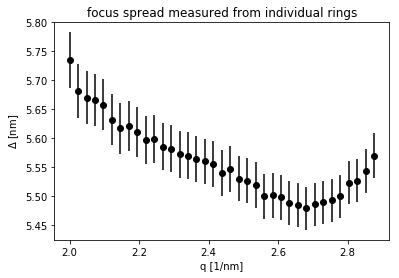

In [29]:
fig, ax = plt.subplots()
ffsq = ax.errorbar(q_s, lil.T[0], yerr=np.sqrt(lil.T[1]), fmt='ko')
ax.set_xlabel('q [1/nm]')
ax.set_ylabel('$\Delta$ [nm]')
ax.set_title('focus spread measured from individual rings')
plt.show()